In [1]:
import pandas as pd
import numpy as np

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
df = pd.read_csv('../raw_data/raw_en.csv')

/home/alechenwolf/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (1,2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
def convert_stars(row):
    if not pd.isnull(row['stars']):
        if row['stars'] > 3:
          return 'Recommended'
        elif row['stars'] == 3:
          return 'Neutral'
        else:
          return 'Not Recommended'
    return row['recommendation']

In [5]:
df['recommendation'] = df.apply(convert_stars, axis = 1)

In [6]:
df_not_recommended = df[df['recommendation'] == 'Not Recommended'].copy()
df_not_recommended.shape

(117917, 8)

In [7]:
df_not_recommended = df_not_recommended[df_not_recommended['source'] != 'steam']

In [8]:
df_not_recommended

,name,date,recommendation,review,playing_hours,source,stars,language
350695,Wyndham Capital Mortgage,24-02-2017,Not Recommended,This was the worst experience ever. It was lik...,NaN,bank,1.0,en
350696,Wyndham Capital Mortgage,14-03-2016,Not Recommended,"A good rate but a very frustrating process, co...",NaN,bank,1.0,en
350697,Wyndham Capital Mortgage,13-08-2017,Not Recommended,They were not upfront. Learn from my mistake.....,NaN,bank,1.0,en
350698,Wyndham Capital Mortgage,26-06-2016,Not Recommended,"Initially, the Mortgage Broker was very friend...",NaN,bank,1.0,en
350716,North American Savings Bank,09-05-2017,Not Recommended,The closing process for a VA loan went smoothl...,NaN,bank,1.0,en
...,...,...,...,...,...,...,...,...
457058,zhong-yi-yao-wen-hua,NaN,Not Recommended,ONly in chinese. Not English subtitles.,NaN,coursera,1.0,en
457059,zhong-yi-yao-wen-hua,NaN,Not Recommended,Need more (understandable) subtitles. Peer-rev...,NaN,coursera,1.0,en
457061,zhong-yi-yao-wen-hua,NaN,Not Recommended,The instructor looks nerves when he talking.,NaN,coursera,1.0,en
457065,zhuangzi,NaN,Not Recommended,Please be advised that this course is not stru...,NaN,coursera,1.0,en


In [10]:
# if you are sure about the language ignore
# !pip install alphabet_detector
from alphabet_detector import AlphabetDetector
ad = AlphabetDetector()

  Using cached alphabet_detector-0.0.7-py3-none-any.whl
You should consider upgrading via the '/home/alechenwolf/.pyenv/versions/3.8.6/envs/lewagon/bin/python3.8 -m pip install --upgrade pip' command.


In [11]:
df_not_recommended['latin'] = df_not_recommended['review'].apply(lambda row: ad.is_latin(row))

In [97]:
#df_not_recommended['n_review'] = df_not_recommended['review'].apply(lambda row: len(row.split()))


In [12]:
df_not_recommended = df_not_recommended[df_not_recommended['latin'] == True].copy()

In [13]:
df_not_recommended['review'].iloc[0]


'This was the worst experience ever. It was like they had never gone through the process before. I could not get a complete list of the documents required. Every other day it was a new request. The appraiser that they hired made so many mistakes I had to send in corrections and then during the underwriting process they had to go back and make more corrections. Wyndum would continue to ask for copies of documents over and over again. There were many documents that I had to send 3 and 4 times because they "lost" them or was not filed correctly, we went through 4 different people through the process. I would NEVER use them. Awful experience!'

In [14]:
n_words = 20
n_embedding = 50

In [15]:
# find a suitable lib for your language
import gensim.downloader as api
print(list(api.info()['models'].keys()))
word2vec = api.load('glove-wiki-gigaword-50')

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']
[==================================================] 100.0% 66.0/66.0MB downloaded


In [16]:
X_train = df_not_recommended['review']

In [103]:
#df_not_recommended = df[df['recommendation'] == 'Not Recommended']
# from gensim.models import Word2Vec
# X_train = df_not_recommended['review']
# word2vec = Word2Vec(sentences=X_train, size = n_embedding, min_count = 5, window = 4)

In [17]:
X_train.iloc[0]

'This was the worst experience ever. It was like they had never gone through the process before. I could not get a complete list of the documents required. Every other day it was a new request. The appraiser that they hired made so many mistakes I had to send in corrections and then during the underwriting process they had to go back and make more corrections. Wyndum would continue to ask for copies of documents over and over again. There were many documents that I had to send 3 and 4 times because they "lost" them or was not filed correctly, we went through 4 different people through the process. I would NEVER use them. Awful experience!'

In [19]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import string

# Function to convert a sentence (list of words) into a matrix representing the words in the embedding space
def embed_sentence(word2vec, sentence):
    embedded_sentence = []
    for c in '?!#*':
        sentence = sentence.replace(c,"")


    for word in sentence.split():
        if word in word2vec:
            embedded_sentence.append(word2vec[word])
        
    return np.array(embedded_sentence)

# Function that converts a list of sentences into a list of matrices
def embedding(word2vec, sentences):
    embed = []
    
    for sentence in sentences:
        embedded_sentence = embed_sentence(word2vec, sentence)
        embed.append(embedded_sentence)
        
    return embed

# Embed the training and test sentences
X_train_embed = embedding(word2vec, X_train)
#X_test_embed = embedding(word2vec, X_test)


# Pad the training and test embedded sentences
X_train_pad = pad_sequences(X_train_embed, dtype='float32', padding='post', maxlen=n_words)
#X_test_pad = pad_sequences(X_test_embed, dtype='float32', padding='post', maxlen=n_words)

In [20]:
len(X_train_pad)

4801

In [21]:
mask = [X_train_pad_one[-1].sum() != 0 for X_train_pad_one in X_train_pad]

In [108]:
index_not_recommended = np.where(mask)
index_not_recommended

(array([   0,    1,    2, ..., 4792, 4799, 4800]),)

In [23]:
X_train_pad = X_train_pad[mask].copy()

In [110]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import  Dense, Masking, LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

def build_encoder(latent_dimension):
    '''returns an encoder model, of output_shape equals to latent_dimension'''

    encoder = Sequential()
    
    encoder.add(Masking(mask_value=0))
    encoder.add(LSTM(16, activation="tanh", return_sequences=True))
    encoder.add(LSTM(latent_dimension, activation="tanh"))
    
    return encoder

In [111]:
from tensorflow.keras.layers import Input
encoder = build_encoder(2)
#encoder.build((None,n_words,n_embedding))
#encoder.summary()

In [112]:
def build_decoder(latent_dimension):
    # $CHALLENGIFY_BEGIN
    decoder = Sequential()
    decoder.add(RepeatVector(n_words)) #RepeatVector add comments
    decoder.add(LSTM(n_embedding, activation='tanh', return_sequences=True))
    decoder.add(TimeDistributed(Dense(n_embedding))) #TimeDistrivuted add comments

    return decoder

In [113]:
decoder = build_decoder(2)
# decoder.build((None,200,100))
# decoder.summary()

In [122]:
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
#opt = SGD(learning_rate=0.01, momentum=0.1, nesterov=True, name="SGD")
def build_autoencoder(encoder, decoder):
    inp = Input(X_train_pad.shape[1:])
    encoded = encoder(inp)
    decoded = decoder(encoded)
    autoencoder = Model(inp, decoded)
    autoencoder.compile(optimizer=opt, loss='mse', metrics = ['mse'])
    return autoencoder

In [123]:
autoencoder = build_autoencoder(encoder, decoder)
#autoencoder.summary()


In [124]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(patience = 20, restore_best_weights=True)

history = autoencoder.fit(X_train_pad, X_train_pad,
         epochs = 1000,
         batch_size = 128,
         verbose = 1,
         validation_split=0.2,
         callbacks=[es])


Epoch 1/1000
18/18 [==============================] - 12s 229ms/step - loss: 0.2340 - mse: 0.2340 - val_loss: 0.2064 - val_mse: 0.2064
Epoch 2/1000
18/18 [==============================] - 0s 13ms/step - loss: 0.2059 - mse: 0.2059 - val_loss: 0.2029 - val_mse: 0.2029
Epoch 3/1000
18/18 [==============================] - 0s 13ms/step - loss: 0.2044 - mse: 0.2044 - val_loss: 0.2024 - val_mse: 0.2024
Epoch 4/1000
18/18 [==============================] - 0s 14ms/step - loss: 0.2040 - mse: 0.2040 - val_loss: 0.2022 - val_mse: 0.2022
Epoch 5/1000
18/18 [==============================] - 0s 13ms/step - loss: 0.2038 - mse: 0.2038 - val_loss: 0.2018 - val_mse: 0.2018
Epoch 6/1000
18/18 [==============================] - 0s 13ms/step - loss: 0.2033 - mse: 0.2033 - val_loss: 0.2014 - val_mse: 0.2014
Epoch 7/1000
18/18 [==============================] - 0s 14ms/step - loss: 0.2027 - mse: 0.2027 - val_loss: 0.2007 - val_mse: 0.2007
Epoch 8/1000
18/18 [==============================] - 0s 14ms/step 

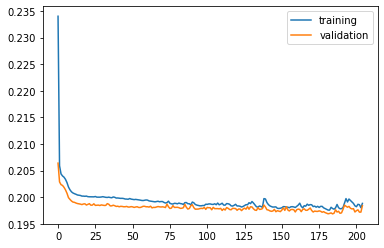

In [125]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label = 'training')
plt.plot(history.history['val_loss'],label = 'validation')
plt.legend()

In [127]:
xy_x_train = encoder.predict(X_train_pad)

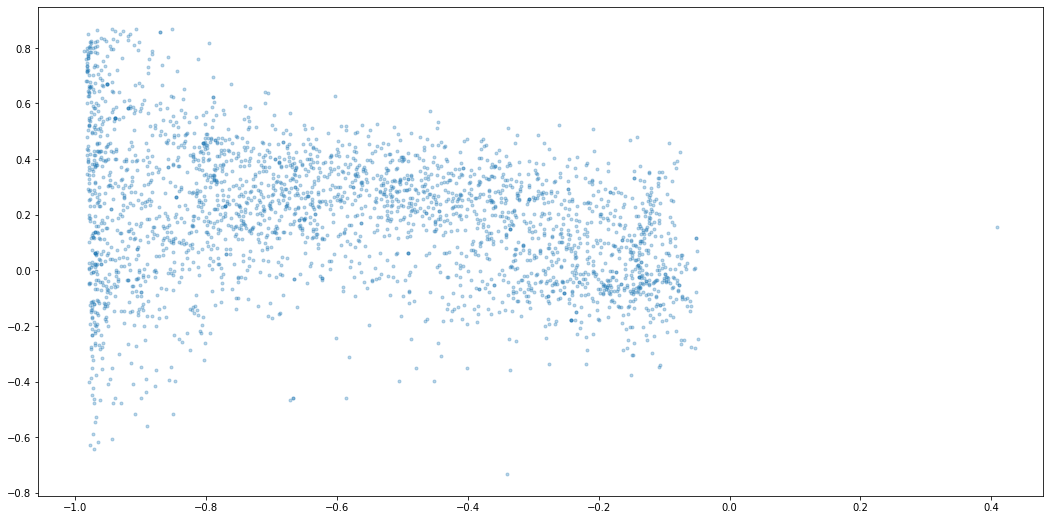

In [128]:
plt.figure(figsize = (18,9))
plt.plot(xy_x_train[:,0],xy_x_train[:,1],linewidth = 0, marker = '.', alpha = 0.3)

In [129]:
np.where((xy_x_train[:,0] > 0.3) & (xy_x_train[:,1] > -0.1))


(array([580]),)

In [130]:
X_train.iloc[index_not_recommended[0][580]]

'The course brings lots of information, but the assessments are not at all creative, so it becomes a lot of theory with little practice.El curso trae mucha información, pero las actividades no son ní un poco creativas. Entonces se converte en mucha teoria con poca practica.'

In [131]:
from sklearn.cluster import KMeans

In [144]:
kmeans = KMeans(n_clusters=10, random_state=0).fit(xy_x_train)

In [145]:
cluster = kmeans.predict(xy_x_train)

In [146]:
encoded_df = pd.DataFrame(xy_x_train, columns = ['X','Y'])
encoded_df['C'] = cluster



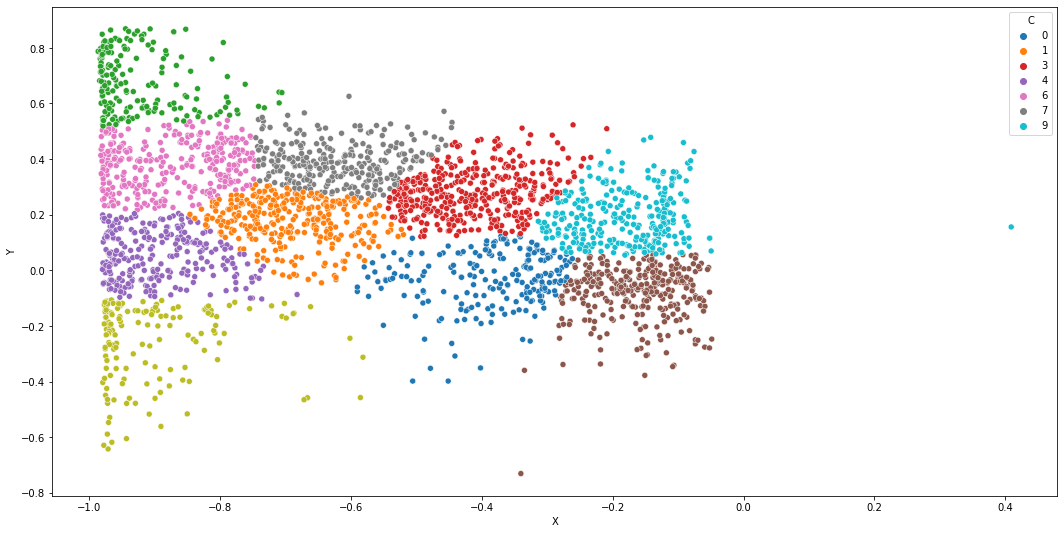

In [147]:
import seaborn as sns

plt.figure(figsize = (18,9))

sns.scatterplot(data =encoded_df,x='X', y='Y', hue = 'C', palette = sns.color_palette("tab10", as_cmap=True)  )


In [155]:
for i in range(10):
  print(f'################Cluster Number {i}#################')
  review_temp = X_train.iloc[index_not_recommended[0][encoded_df[encoded_df['C'] == i].index]].head(5)
  for review in review_temp:
    print(review)
    print('---------------------')
#tfdif

################Cluster Number 0#################
Rep was extremely professional, friendly, and helpful when we first spoke. In fact, from my initial round of calls, I thought I was going to select him out of the five Lending Tree lenders (plus two banks I talked to directly). But then when I sent an email to all the lenders saying "OK, the contract is signed. I want to select a lender and lock my rate TOMORROW, so please send me your best current rate and fees etc. with these EXACT loan parameters. It took the rep from NASB over a week to respond. So I replied to him "thanks but you are too late, I have selected someone else and already locked my rate." Over the following few weeks I continued to receive emails from him saying "when you are ready to proceed with your loan, let me know". We CLOSED on January 8th, and on February 5th I got another such email. I guess he didn't really ever read my emails. I also told him on the phone that he had missed the boat, but that seemed to fall o